## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(2 балл)**

## Срок выполнения задания:
Софт дедлайн - 8 октября 23:59  
Хард дедлайн - 15 октября 23:59


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [3]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [4]:
images_train, labels_train = next(iter(train_loader))

In [5]:
from pathlib import Path

# Предполагается, что YT_PREFIX и output[0].path определены ранее в коде
output_path = "ytTable:/" + str(Path("//home/hc/predict/desc/snb/dyn_interests/v1/clickstream_tier1_daily/") / '2025-09-01')
output_path

'ytTable:/\\\\home\\hc\\predict\\desc\\snb\\dyn_interests\\v1\\clickstream_tier1_daily\\2025-09-01'

In [6]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

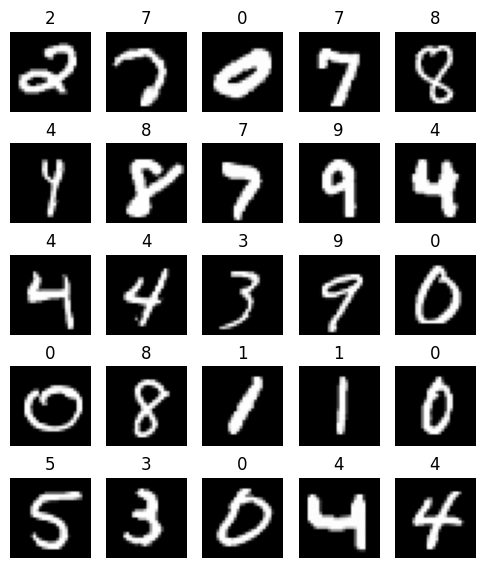

In [7]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [8]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [10]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [11]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

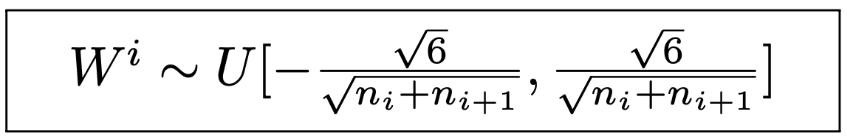

In [16]:
def init_layer_xavier(layer):
    fan_in = layer.weight.size(1)
    fan_out = layer.weight.size(0)
    std = (2.0 / (fan_in + fan_out)) ** 0.5 
    
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

init_layer_xavier(layer_1)
init_layer_xavier(layer_2)

network_xavier = nn.Sequential(
    layer_1,
    nn.Tanh(),  
    layer_2
)

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

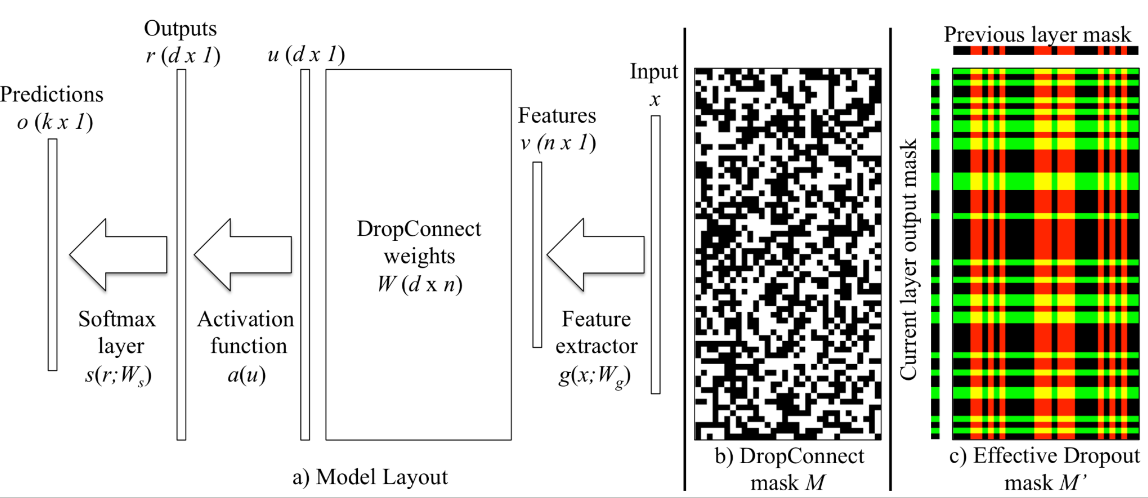

In [ ]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p
    
    def forward(self, x):
        if self.training:
            mask = torch.ones_like(self.linear.weight).bernoulli_(1 - self.p)
            mask.requires_grad = False
        else:
            mask = torch.ones_like(self.linear.weight) * (1 - self.p)
            mask.requires_grad = False
        
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output


Основа для сети, которую будем обучать:

In [ ]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [ ]:
layers_simple = [
    nn.Linear(7 * 7 * 4, 128), 
    nn.ReLU(),
    nn.Linear(128, 128), 
    nn.ReLU(),
    nn.Linear(128, 10)]
    


Обучим получившуюся сеть:


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [ ]:
##### YOUR CODE HERE #####

### Часть 3: Layer Normalization

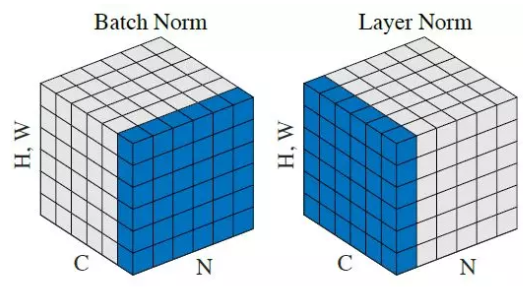

#### 3.1 Реализуйте Layer Normalization **(2 балл)**

In [40]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return (x - mean) / (std + self.eps) * self.weight + self.bias

#### Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [21]:
#сеть без нормализации
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.layers(x)

# Сеть с LayerNorm
class SimpleNetWithNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 128),
            LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.layers(x)


In [22]:
def train_simple(model, epochs=5):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for X, y in train_loader:
            X = X.view(X.size(0), -1)
            
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.3f}')
    
    return losses

Без LayerNorm
Epoch 1, Loss: 0.310
Epoch 2, Loss: 0.125
Epoch 3, Loss: 0.084
Epoch 4, Loss: 0.065
Epoch 5, Loss: 0.051

С LayerNorm
Epoch 1, Loss: 0.268
Epoch 2, Loss: 0.100
Epoch 3, Loss: 0.071
Epoch 4, Loss: 0.054
Epoch 5, Loss: 0.043


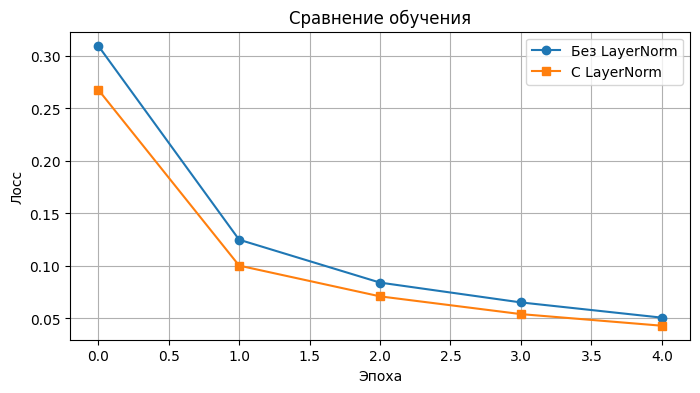

In [25]:
# Сравнение
print("Без LayerNorm")
model1 = SimpleNet()
losses1 = train_simple(model1)

print("\nС LayerNorm")
model2 = SimpleNetWithNorm()
losses2 = train_simple(model2)

# Простой график
plt.figure(figsize=(8, 4))
plt.plot(losses1, label='Без LayerNorm', marker='o')
plt.plot(losses2, label='С LayerNorm', marker='s')
plt.xlabel('Эпоха')
plt.ylabel('Лосс')
plt.title('Сравнение обучения')
plt.legend()
plt.grid(True)
plt.show()